In [ ]:
#|hide
from nbdev import *

# VASP Testing
> This are tests for various aspects of the "typical" use with VASP calculator. At the same time this is an example of the typical VASP workflow with multiple temperatures scanning.

In [ ]:
#|vasp
# Import VASP calculator and unit modules
from ase.calculators.vasp import Vasp
from ase import units as un
from os.path import isfile
import os

# The sample generator, monitoring display and dfset writer
from hecss import HECSS
from hecss.util import write_dfset
from hecss.monitor import plot_stats

# Numerical and plotting routines
import numpy as np
from matplotlib import pyplot as plt
from collections import defaultdict
from tempfile import TemporaryDirectory
from glob import glob

In [ ]:
#|vasp
# Quick test using conventional unit cell
supercell = '2x2x2'
supercell = '1x1x1'

In [ ]:
#|vasp
# Directory in which our project resides
base_dir = f'example/VASP_3C-SiC/{supercell}/'
calc_dir = TemporaryDirectory(dir='TMP')

In [ ]:
#| vasp
# Read the structure (previously calculated unit(super) cell)
# The command argument is specific to the cluster setup
calc = Vasp(label='cryst', directory=f'{base_dir}/sc_{supercell}/', restart=True)

# This just makes a copy of atoms object
# Do not generate supercell here - your atom ordering will be wrong!
cryst = calc.atoms.repeat(1)

In [ ]:
#|vasp
# Setup the calculator - single point energy calculation
# The details will change here from case to case
# We are using run-vasp from the current directory!
calc.set(directory=f'{calc_dir.name}/sc')
calc.set(command=f'{os.getcwd()}/run-calc.sh "vasp_test"')
calc.set(nsw=0)
cryst.set_calculator(calc)

In [ ]:
#|vasp
print('Stress tensor: ', end='')
for ss in calc.get_stress()/un.GPa:
    print(f'{ss:.3f}', end=' ')
print('GPa')

Stress tensor: 0.017 0.017 0.017 0.000 0.000 0.000 GPa


In [ ]:
#|vasp
# Prepare space for the results.
# We use defaultdict to automatically
# initialize the items to empty list.
samples = defaultdict(lambda : [])

# Space for amplitude correction data
xsl = []

In [ ]:
#|vasp
# Build the sampler
hecss = HECSS(cryst, calc, 
              directory=calc_dir.name,
              w_search = True,
              pbar=True,
              )

  0%|          | 0/5 [00:00<?, ?it/s]

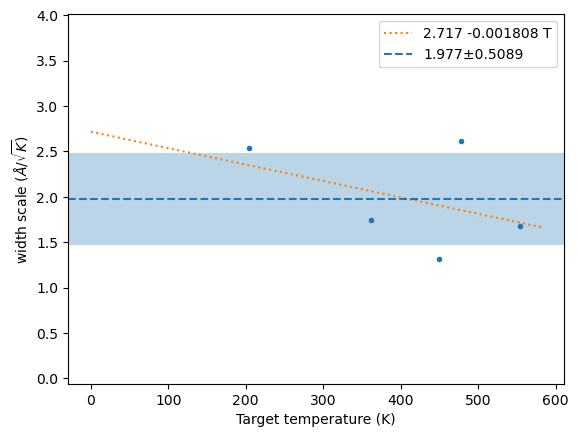

In [ ]:
#|vasp
N = 5
m, s, xscl = hecss.estimate_width_scale(5)
wm = np.array(hecss._eta_list).T
y = np.sqrt((3*wm[1]*un.kB)/(2*wm[2]))
plt.plot(wm[1], y, '.');
x = np.linspace(0, 1.05*wm[1].max(), 2)
fit = np.polyfit(wm[1], y, 1)
plt.plot(x, np.polyval(fit, x), ':', label=f'{fit[1]:.4g} {fit[0]:+.4g} T')
plt.axhline(m, ls='--', label=f'{m:.4g}±{s:.4g}')
plt.axhspan(m-s, m+s, alpha=0.3)
plt.ylim(m-4*s, m+4*s)
plt.xlabel('Target temperature (K)')
plt.ylabel('width scale ($\\AA/\\sqrt{K}$)')
plt.legend();

In [ ]:
#|hide
#|vasp
assert len(glob(f'{calc_dir.name}/w_est/*')) == N

In [ ]:
#|vasp
# Desired number of samples and T list.
N = 5
T_list = (100, 200, 300)
for T in T_list:
    samples[T] += hecss.sample(T, N) 

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
#|hide
#|vasp
for T in T_list:
    assert len(glob(f'{calc_dir.name}/T_{T:.1f}K/smpl/*')) == len(samples[T])

In [ ]:
#|hide
#|vasp
# Test if all the calculations are run in separate dirs only once 
for d in ([f'{calc_dir.name}/sc'] + 
          glob(f'{calc_dir.name}/w_est/*') + 
          glob(f'{calc_dir.name}/*/smpl/*')):
    assert len(glob(f'{d}/slurm*.out')) == 1

In [ ]:
#|hide
#|vasp
calc_dir.cleanup()